# Image Classification with Principal Components Analysis

I recently got involved with a hack day at the University of Sussex, working on a challenge proposed by [Deckchair](https://www.deckchair.com/), a company that provides high quality webcams for businesses around the world. They routinely capture some amazing images, such as lightning strikes and fireworks displays, but these are currently identified manually by eye. The challenge was to identify 'interesting' images automagically. Here's a write up of my approach using Principal Components Analysis (PCA).

I chose PCA as it's a relatively straightforward technique to understand. There are out-of-the-box implementations available in Python, useful for prototyping, and in C, in case you wish to scale.


## Packages

Apart from Numpy, the only specialist packages required were [skimage](http://scikit-image.org/) (a Python image processing library) for plotting the images, and [sklearn](http://scikit-learn.org/) (a machine learning library) for our PCA implementation and clustering.

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np

from skimage import io

from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth


## Data

Deckchair provided us with ~75000 low resolution RGB images from a webcam based in Venice to prototype with. To begin with I flattened the RGB images to monochrome (by taking the mean of each channel) to make the data easier to handle, and flattened the 2D array to one dimension.

In [32]:
len(os.listdir('data/300x169/'))

76154

In [2]:
n = 1000 # number of images to use

img = []
for d in os.listdir('data/300x169/')[0:n]:
    img.append(io.imread('data/300x169/'+d).mean(axis=2).flatten())

img = np.array(img)
img.shape    

(1000, 50700)

Now have a column array of pixel values for each image

In [33]:
print img.shape

(1000, 50700)


To recreate the images later on we need the image dimensions, so we grab them from a test image

In [34]:
m,n = io.imread('data/favourites/300x169/2014-06-29_22-25.jpg').shape[0:2]    
print m,n

169 300


## PCA

Now we can decompose this array of image pixels to find the principal components. First initialise a PCA object from the `sklearn` library, then, using the `fit_transform` method, fit it to the data and apply the dimensionality reduction. 

In [11]:
sklearn_pca = PCA(n_components=3)
Y_sklearn = sklearn_pca.fit_transform(img)

We now have an object, `sklearn_pca`, trained on our data. The full image data for each principal component is given in `components_`

In [35]:
sklearn_pca.components_.shape

(3, 50700)

We can plot each principal component as a monochrome image.

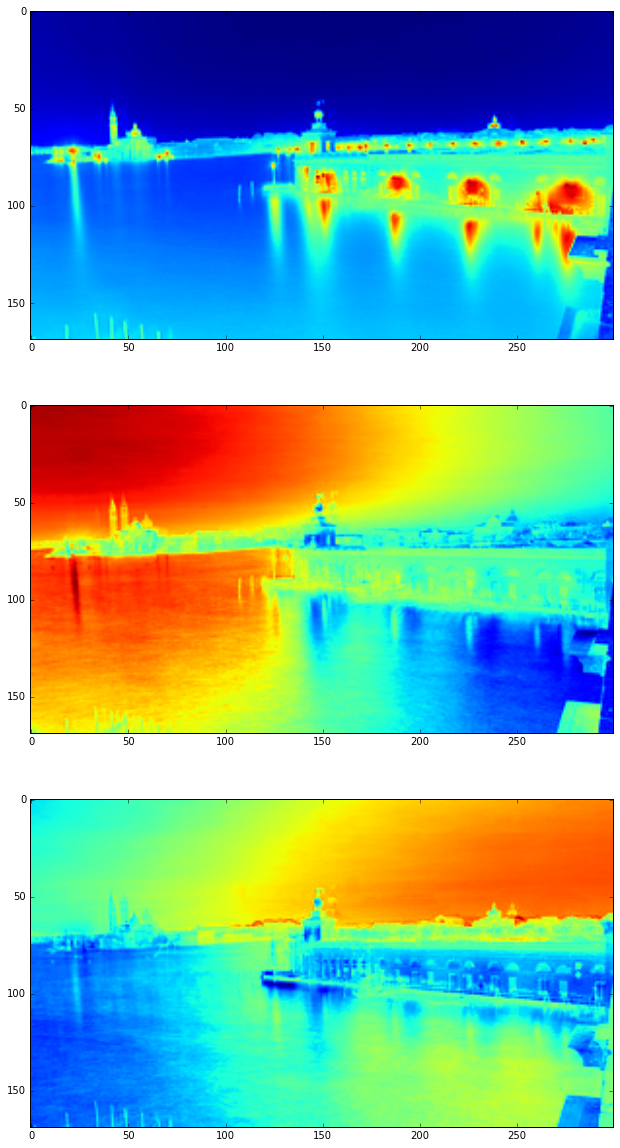

In [36]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(40, 20))

ax = [ax1,ax2,ax3]

for i in range(0,sklearn_pca.get_params()['n_components']):
    ax[i].imshow(sklearn_pca.components_[i,:].reshape(m,n))

We can see some interesting patterns just from the principal components. The first principal component, which accounts for the most variability in the data, appears to highlight areas that light up after dark: windows, streetlights, reflections in the water. The second and third principal components are quite similar, showing more variation in the sky but from different directions, perhaps picking up the changes in sky colour during sunset and sunrise.

We can also visualise the values of each principal component for each image. The plot below shows this, with a few points labelled to allow manual look up and comparison.

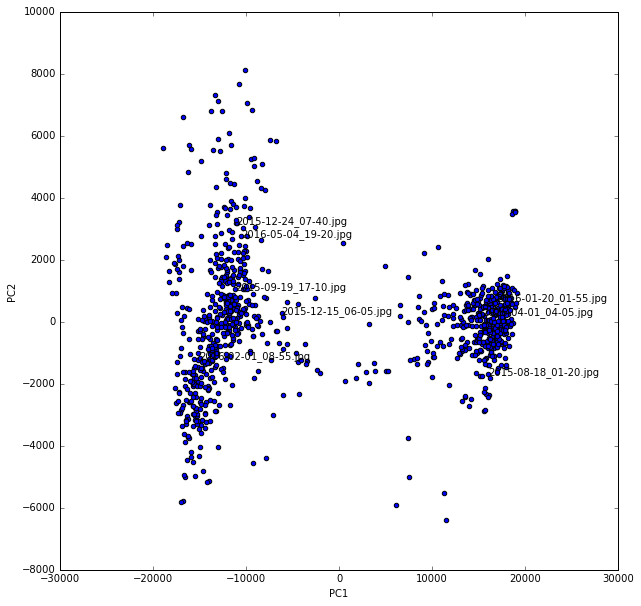

In [71]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.scatter(Y_sklearn[:,0],Y_sklearn[:,1])


# add labels to some of the points so we can manually go and check them to see differences
for i, txt in enumerate(os.listdir('data/300x169/')[0:n]):
    if(i%40 == 0):
        ax.annotate(txt, (Y_sklearn[i,0],Y_sklearn[i,1]))

From this plot we can already see some obvious structure. To quantify this, we can cluster the data and look at the bulk properties of each cluster.

## Clustering

Using the meanshift algorithm we can cluster in PC space. I chose Meanshift as it's non-parametric: you don't need to specify up front how many clusters you want, it automatically chooses the ideal number of clusters. For an accessible introduction, see [here](http://sociograph.blogspot.co.uk/2011/11/accessible-introduction-to-mean-shift.html).

First we estimate the ideal bandwidth with `scikitlearn`'s built in function. 

In [39]:
bandwidth = estimate_bandwidth(Y_sklearn, quantile=0.2, n_samples=500)
bandwidth

3742.6498200637361

Can now initialise a `MeanShift` object with the estimate bandwidth.

In [40]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms

MeanShift(bandwidth=3742.6498200637361, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=1, seeds=None)

Then fit this to our reduced data. 

In [42]:
ms.fit(Y_sklearn)

MeanShift(bandwidth=3742.6498200637361, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=1, seeds=None)

Returns the following number of labels

In [48]:
print len(np.unique(ms.labels_))

7


We can also pull out the coordinates of the center of each cluster.

In [50]:
ms.cluster_centers_

array([[  1.63745465e+04,  -4.30990813e+01,   2.44453535e+01],
       [ -1.21909675e+04,   3.47911178e+02,   3.56931585e+02],
       [  4.09476180e+03,  -9.64753660e+02,  -1.11295562e+03],
       [  7.25265941e+00,  -8.91119322e+02,  -1.76596467e+03],
       [  7.01488994e+03,  -4.89033070e+03,  -3.83216862e+03],
       [  1.14179674e+04,  -5.96759892e+03,  -4.44431226e+03],
       [ -5.98246757e+03,  -8.82593607e+02,  -6.88951896e+03]])

Using the label data we can plot the first two PCs again, but this time coloured by cluster, and with the cluster centers plotted alongside. We can also plot the 2nd and 3rd PCs against each other. Note that there is less variability in the second plot, as expected. 

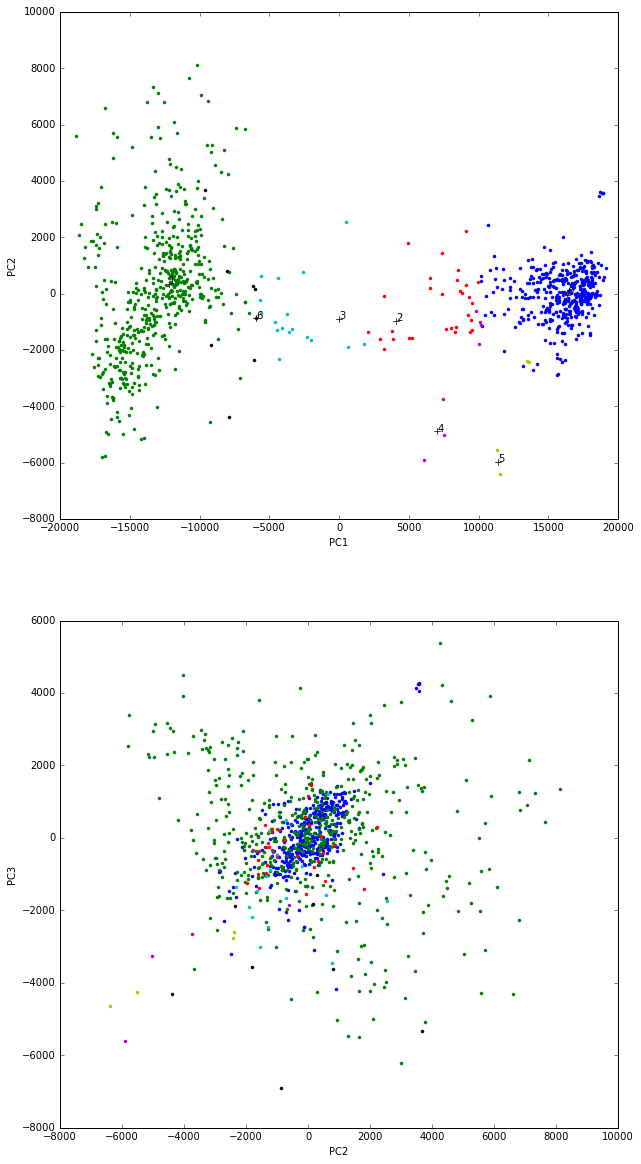

In [73]:
from itertools import cycle

fig, (ax1,ax2) = plt.subplots(2,figsize=(10,20))


colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

# 1st / 2nd PCs
for i in np.unique(ms.labels_):
    c = colors.next()
    ax1.plot(Y_sklearn[ms.labels_==i,0],Y_sklearn[ms.labels_==i,1],c+'.')
    ax1.plot(ms.cluster_centers_[:,0],ms.cluster_centers_[:,1],c+'+')
    ax1.annotate(i, (ms.cluster_centers_[i,0]+10,ms.cluster_centers_[i,1]))
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")

# 2nd / 3rd PCs
for i in np.unique(ms.labels_):
    c = colors.next()
    ax2.plot(Y_sklearn[ms.labels_==i,1],Y_sklearn[ms.labels_==i,2],c + '.')
    ax2.set_xlabel("PC2")
    ax2.set_ylabel("PC3")
    

Since we have the labels we can go back and find the mean value of the image pixel weights in each cluster. Below is a plot of the mean image for each cluster. Note how some appear to identify night time activity, whereas others highlight water movement.

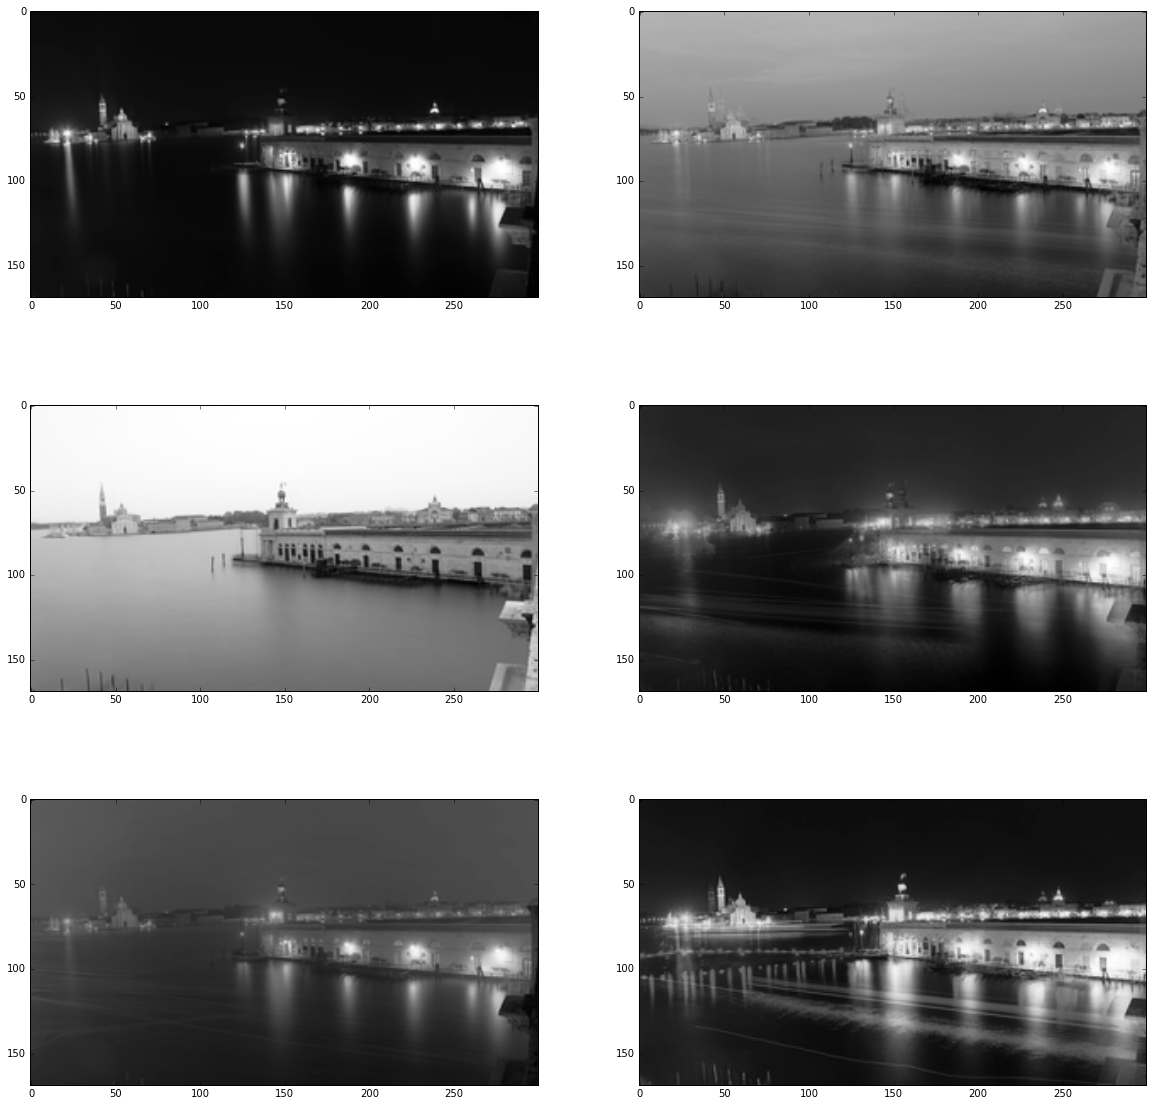

In [25]:
fig, axes = plt.subplots(3,2,figsize=(20,20))

axes[0,0].imshow(np.mean(img[ms.labels_==0],axis=0).reshape(m,n),cmap='Greys_r')
axes[1,0].imshow(np.mean(img[ms.labels_==1],axis=0).reshape(m,n),cmap='Greys_r')
axes[2,0].imshow(np.mean(img[ms.labels_==2],axis=0).reshape(m,n),cmap='Greys_r')
axes[0,1].imshow(np.mean(img[ms.labels_==3],axis=0).reshape(m,n),cmap='Greys_r')
axes[1,1].imshow(np.mean(img[ms.labels_==4],axis=0).reshape(m,n),cmap='Greys_r')
axes[2,1].imshow(np.mean(img[ms.labels_==5],axis=0).reshape(m,n),cmap='Greys_r')

## Fresh Data

Now that we have a trained model with classifier, we can apply our pipeline to new data. This will fold the image in to our modelled principal components to find where in this reduced dimensional space the image lies, and then classify it based on our meanshift clustering.

First, load some new images.

In [52]:
img_test = []
for d in os.listdir('data/300x169/')[n:2*n]:
    img_test.append(io.imread('data/300x169/'+d).mean(axis=2).flatten())

img_test = np.array(img_test)
img_test.shape    

(300, 50700)

Now transform the new data with the `sk_learn` object we trained earlier...

In [57]:
Y = sklearn_pca.transform(img_test)
Y.shape

(300, 3)

... and classify with our trained meanshift

In [58]:
Y_labels = ms.predict(Y)

Can now plot the PCs for each new image, 1st against 2nd and 2nd against 3rd as above.

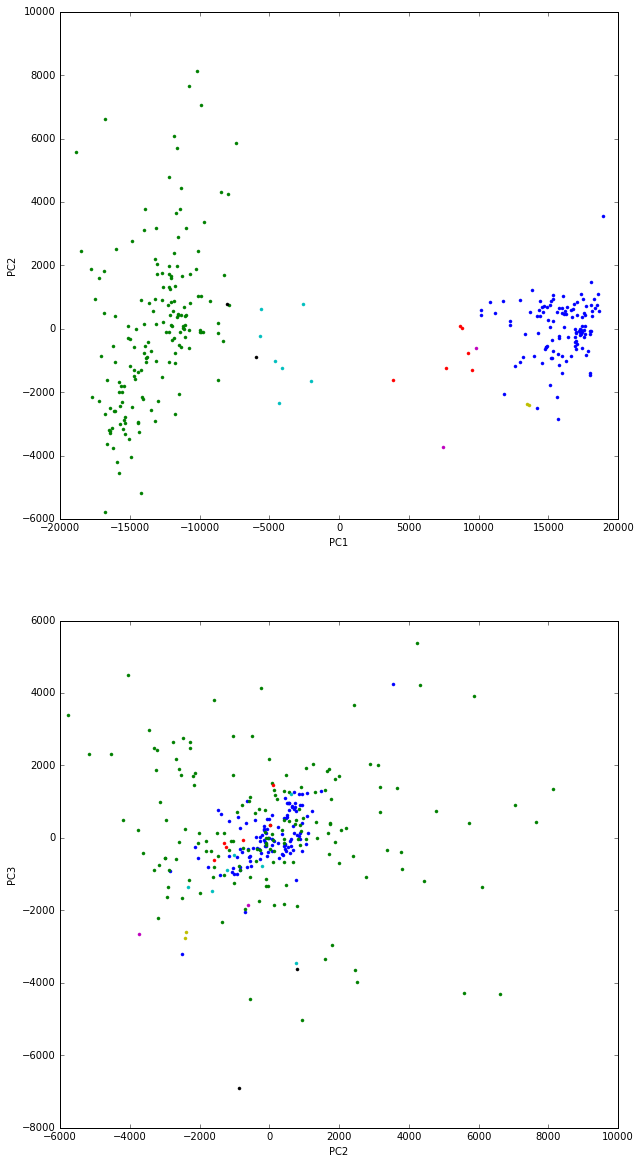

In [72]:
from itertools import cycle

fig, (ax1,ax2) = plt.subplots(2,figsize=(10,20))


colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

for i in np.unique(Y_labels):
    ax1.plot(Y[Y_labels==i,0],Y[Y_labels==i,1],colors.next() + '.')
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")

    
for i in np.unique(Y_labels):
    ax2.plot(Y[Y_labels==i,1],Y[Y_labels==i,2],colors.next() + '.')
    ax2.set_xlabel("PC2")
    ax2.set_ylabel("PC3")

## Summing Up

I've demonstrated how to extract the principal components from an array of images and classify in the reduced dimensional space. 

As an extension you could include the entire RGB array. This would take longer to extract the PCs, but the added information could aid outlier detection. I also started work on a naive outlier detector, based on distance from cluster centres. 